#**Task 2**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [2]:
!pip install python-mnist

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization,Conv2D,MaxPooling2D, ReLU, AveragePooling2D, Activation
from keras.models import Model, clone_model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
import keras
from keras.optimizers import Adam
import os
import numpy as np
import cv2
from scipy.ndimage.interpolation import shift
from skimage.transform import rotate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from mnist import MNIST
from PIL import Image, ImageOps
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn

##Part 1

### Importing, Preprocessing and Augmenting Dataset

In [4]:
root_path = "/content/drive/MyDrive/train"
def first_preprocessing():
  img_data = []
  class_data = []
  for i in os.listdir(root_path):
    sub_folder = root_path + "/" + i
    for j in os.listdir(sub_folder):
      image_path = sub_folder + "/" + j
      img = cv2.imread(image_path)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
      rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
      dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
      contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                      cv2.CHAIN_APPROX_NONE)
      im2 = img.copy()
      img = Image.fromarray(im2)
      X = []
      Y = []
      W = []
      H = []
      for cnt in contours:
          x, y, w, h = cv2.boundingRect(cnt)
          X.append(x)
          Y.append(y)
          W.append(w)
          H.append(h)
      if len(contours) > 1:
        x = min(X)
        y = min(Y)
        w = max(W)
        h = sum(H) + max(Y) - min(Y) - min(H)
      else:
        x, y, w, h = cv2.boundingRect(contours[0])
      im2 = img.crop((x, y, x+w, y+h))
      im2 = ImageOps.expand(im2,border=75,fill='white')
      im2 = ImageOps.invert(im2)
      im2 = np.array(im2)
      img_data.append(im2)
      class_data.append(i)
  return img_data, class_data
X, Y = first_preprocessing()

In [5]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
dir = []
def create_dataset(X, Y):
   
    img_data_array=[]
    class_name=[]
   
    for i in range(len(X)):
      image = X[i]
      image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
      image = np.array(image)
      image = image.astype('float32')
      image /= 255
      left = shift(image, [0, -2, 0], cval=0)
      right = shift(image, [0, 2, 0], cval=0)
      up = shift(image, [2, 0, 0], cval=0)
      down = shift(image, [-2, 0, 0], cval=0)
      img_data_array.append(image)
      class_name.append(Y[i])
      img_data_array.append(left)
      class_name.append(Y[i])
      img_data_array.append(right)
      class_name.append(Y[i])
      img_data_array.append(up)
      class_name.append(Y[i])
      img_data_array.append(down)
      class_name.append(Y[i])
      for angle in range(-30, 31, 10):
        if angle != 0:
          rotated = rotate(image, angle)
          img_data_array.append(rotated)
          class_name.append(Y[i])
    return img_data_array, class_name
X, Y = create_dataset(X, Y)

In [6]:
X_train_first, X_test_first, Y_train_first, Y_test_first = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [7]:
encoderFirst = OneHotEncoder(sparse=False)
Y_train_first = np.array(Y_train_first)
Y_test_first = np.array(Y_test_first)
Y_train_first = Y_train_first.reshape(-1,1)
Y_test_first = Y_test_first.reshape(-1, 1)
Y_train_first = encoderFirst.fit_transform(Y_train_first)
Y_test_first = encoderFirst.transform(Y_test_first)

In [8]:
X_train_first = np.array(X_train_first)
X_train_first.shape

(21824, 28, 28, 3)

In [9]:
X_test_first = np.array(X_test_first)
X_test_first.shape

(5456, 28, 28, 3)

In [10]:
Y_test_first.shape

(5456, 62)

In [11]:
Y_train_first.shape

(21824, 62)

In [12]:
early = EarlyStopping(monitor="val_accuracy", patience=5, verbose = 2,  restore_best_weights=True)

###First Part Model

In [13]:
model_part_one_checkpoint = ModelCheckpoint("checkpoints/model_part_one_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [14]:
model_part_one = Sequential()
model_part_one.add(Conv2D(32, kernel_size = (3, 3), activation="relu", input_shape=(28, 28, 3)))
model_part_one.add(MaxPooling2D())
model_part_one.add(Conv2D(64, activation="relu", kernel_size=(5, 5)))
model_part_one.add(MaxPooling2D())
model_part_one.add(Conv2D(128, activation="relu", kernel_size=(3, 3)))
model_part_one.add(MaxPooling2D())
model_part_one.add(Flatten())
model_part_one.add(Dense(256, activation="relu"))
model_part_one.add(BatchNormalization())
model_part_one.add(Dropout(0.2))
model_part_one.add(Dense(62, activation="softmax"))
model_part_one.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_part_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [15]:
history_part_one = model_part_one.fit(
    X_train_first, Y_train_first,
    validation_data = (X_test_first, Y_test_first), 
    batch_size=32,
    epochs = 100, callbacks=[early, model_part_one_checkpoint])

Epoch 1/100
682/682 [==============================] - 27s 38ms/step - loss: 2.0490 - accuracy: 0.4709 - val_loss: 0.8361 - val_accuracy: 0.7304

Epoch 00001: saving model to checkpoints/model_part_one_checkpoint
INFO:tensorflow:Assets written to: checkpoints/model_part_one_checkpoint/assets
Epoch 2/100
682/682 [==============================] - 26s 38ms/step - loss: 0.5411 - accuracy: 0.8296 - val_loss: 0.5716 - val_accuracy: 0.8101

Epoch 00002: saving model to checkpoints/model_part_one_checkpoint
INFO:tensorflow:Assets written to: checkpoints/model_part_one_checkpoint/assets
Epoch 3/100
682/682 [==============================] - 26s 38ms/step - loss: 0.3715 - accuracy: 0.8731 - val_loss: 0.4580 - val_accuracy: 0.8413

Epoch 00003: saving model to checkpoints/model_part_one_checkpoint
INFO:tensorflow:Assets written to: checkpoints/model_part_one_checkpoint/assets
Epoch 4/100
682/682 [==============================] - 26s 38ms/step - loss: 0.2904 - accuracy: 0.8960 - val_loss: 0.4606

In [16]:
model_part_one.save("model_part_one.hd5")

INFO:tensorflow:Assets written to: model_part_one.hd5/assets


### Loss Analysis

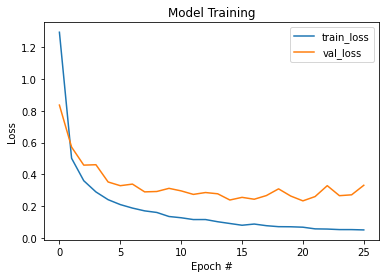

In [17]:
plt.plot(history_part_one.history["loss"], label="train_loss")
plt.plot(history_part_one.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/FirstLoss.png")

### Accuracy Analysis

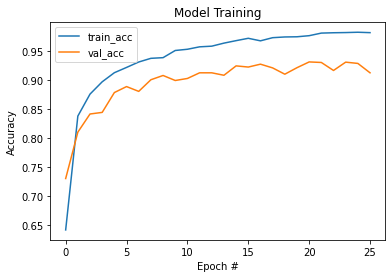

In [18]:
plt.plot(history_part_one.history["accuracy"], label="train_acc")
plt.plot(history_part_one.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/FirstAccuracy.png")

##Part 2

### Second Dataset Importing

In [19]:
dirs = [f"Sample00{i}" for i in range(1, 11)]

In [20]:
dirs[-1] = "Sample010"

In [21]:
second_pretrained_data = []
second_pretrained_class = []
for i in range(len(X)):
  if Y[i] in dirs:
    image = X[i]
    second_pretrained_data.append(image)
    second_pretrained_class.append(Y[i])

In [22]:
second_pretrained_data = np.array(second_pretrained_data)
second_pretrained_class = np.array(second_pretrained_class)

In [23]:
second_pretrained_class = second_pretrained_class.reshape(-1, 1)

In [24]:
second_pretrained_encoder = OneHotEncoder(sparse=False)
second_pretrained_class = second_pretrained_encoder.fit_transform(second_pretrained_class)

In [25]:
X_train_second, X_test_second, Y_train_second, Y_test_second = train_test_split(second_pretrained_data, second_pretrained_class)

###Second Pretrained Model

In [26]:
second_pretrained_model = clone_model(model_part_one)
second_pretrained_model.set_weights(model_part_one.get_weights())

In [27]:
second_pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [28]:
second_pretrained_model_mnist = keras.models.Sequential(second_pretrained_model.layers[:-1])

In [29]:
second_pretrained_model_mnist.add(Dense(10, activation="softmax"))
second_pretrained_model_mnist.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)              

In [30]:
second_pretrained_model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
second_pretrained_model_checkpoint = ModelCheckpoint("checkpoints/second_pretrained_model_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [32]:
second_pretrained_history = second_pretrained_model_mnist.fit(X_train_second, Y_train_second, batch_size=32, validation_data=(X_test_second, Y_test_second), verbose=2, epochs=50, callbacks=[early, second_pretrained_model_checkpoint])

Epoch 1/50
104/104 - 5s - loss: 0.4455 - accuracy: 0.8833 - val_loss: 0.0513 - val_accuracy: 0.9900

Epoch 00001: saving model to checkpoints/second_pretrained_model_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_pretrained_model_checkpoint/assets
Epoch 2/50
104/104 - 4s - loss: 0.0327 - accuracy: 0.9955 - val_loss: 0.0153 - val_accuracy: 0.9973

Epoch 00002: saving model to checkpoints/second_pretrained_model_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_pretrained_model_checkpoint/assets
Epoch 3/50
104/104 - 4s - loss: 0.0135 - accuracy: 0.9988 - val_loss: 0.0087 - val_accuracy: 0.9982

Epoch 00003: saving model to checkpoints/second_pretrained_model_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_pretrained_model_checkpoint/assets
Epoch 4/50
104/104 - 4s - loss: 0.0086 - accuracy: 0.9997 - val_loss: 0.0044 - val_accuracy: 1.0000

Epoch 00004: saving model to checkpoints/second_pretrained_model_checkpoint
INFO:tensorflow:Assets wr

In [33]:
second_pretrained_model_mnist.save("second_pretrained_model_mnist.hd5")

INFO:tensorflow:Assets written to: second_pretrained_model_mnist.hd5/assets


###Second Pretrained Loss Analysis

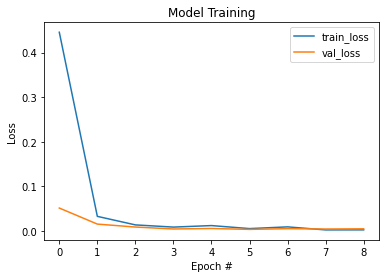

In [34]:
plt.plot(second_pretrained_history.history["loss"], label="train_loss")
plt.plot(second_pretrained_history.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/SecondPretrainedLoss.png")

###Second Pretrained Accuracy Analysis

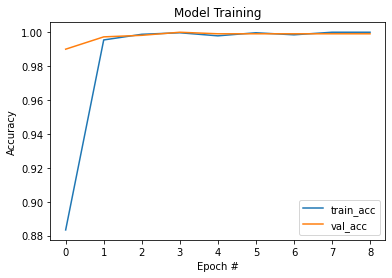

In [35]:
plt.plot(second_pretrained_history.history["accuracy"], label="train_acc")
plt.plot(second_pretrained_history.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/SecondPretrainedAccuracy.png")

###Second Pretrained Random Model

In [36]:
second_pretrained_random_model = Sequential()
second_pretrained_random_model.add(Conv2D(32, kernel_size = (3, 3), activation="relu", input_shape=(28, 28, 3)))
second_pretrained_random_model.add(MaxPooling2D())
second_pretrained_random_model.add(Conv2D(64, activation="relu", kernel_size=(5, 5)))
second_pretrained_random_model.add(MaxPooling2D())
second_pretrained_random_model.add(Conv2D(128, activation="relu", kernel_size=(3, 3)))
second_pretrained_random_model.add(MaxPooling2D())
second_pretrained_random_model.add(Flatten())
second_pretrained_random_model.add(Dense(256, activation="relu"))
second_pretrained_random_model.add(BatchNormalization())
second_pretrained_random_model.add(Dropout(0.2))
second_pretrained_random_model.add(Dense(10, activation="softmax"))
second_pretrained_random_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
second_pretrained_random_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [37]:
second_pretrained_random_checkpoint = ModelCheckpoint("checkpoints/second_pretrained_random_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [38]:
second_pretrained_random_history = second_pretrained_random_model.fit(X_train_second, Y_train_second, batch_size=32, validation_data=(X_test_second, Y_test_second), verbose=2, epochs=50, callbacks=[early, second_pretrained_random_checkpoint])

Epoch 1/50
104/104 - 5s - loss: 0.5359 - accuracy: 0.8388 - val_loss: 1.4461 - val_accuracy: 0.6400

Epoch 00001: saving model to checkpoints/second_pretrained_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_pretrained_random_checkpoint/assets
Epoch 2/50
104/104 - 4s - loss: 0.1481 - accuracy: 0.9612 - val_loss: 0.7043 - val_accuracy: 0.8836

Epoch 00002: saving model to checkpoints/second_pretrained_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_pretrained_random_checkpoint/assets
Epoch 3/50
104/104 - 4s - loss: 0.0556 - accuracy: 0.9900 - val_loss: 0.2953 - val_accuracy: 0.9209

Epoch 00003: saving model to checkpoints/second_pretrained_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_pretrained_random_checkpoint/assets
Epoch 4/50
104/104 - 4s - loss: 0.0696 - accuracy: 0.9815 - val_loss: 0.1626 - val_accuracy: 0.9518

Epoch 00004: saving model to checkpoints/second_pretrained_random_checkpoint
INFO:tensorflow:As

In [39]:
second_pretrained_random_model.save("second_pretrained_random_model.hd5")

INFO:tensorflow:Assets written to: second_pretrained_random_model.hd5/assets


###Second Pretrained Random Loss Analysis

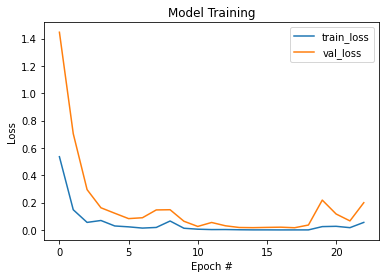

In [40]:
plt.plot(second_pretrained_random_history.history["loss"], label="train_loss")
plt.plot(second_pretrained_random_history.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/SecondPretrainedRandomLoss.png")

###Second Pretrained Random Accuracy Analysis

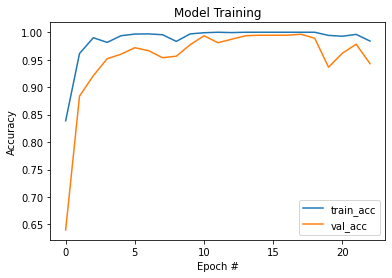

In [41]:
plt.plot(second_pretrained_random_history.history["accuracy"], label="train_acc")
plt.plot(second_pretrained_random_history.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/SecondPretrainedRandomAccuracy.png")

###Import MNIST Dataset

In [42]:
!pip install python-mnist

In [43]:
mndata = MNIST("samples")
X_train_mnist, Y_train_mnist = mndata.load_training()
X_test_mnist, Y_test_mnist = mndata.load_testing()

In [44]:
X_train_mnist = np.array(X_train_mnist)
Y_train_mnist = np.array(Y_train_mnist)
X_test_mnist = np.array(X_test_mnist)
Y_test_mnist = np.array(Y_test_mnist)

In [45]:
X_train_mnist = X_train_mnist.reshape(60000, 28, 28)
X_test_mnist = X_test_mnist.reshape(10000, 28, 28)
Y_train_mnist = Y_train_mnist.reshape(-1, 1)
Y_test_mnist = Y_test_mnist.reshape(-1, 1)

In [46]:
X_train_mnist.shape

(60000, 28, 28)

In [47]:
Y_train_mnist.shape

(60000, 1)

In [48]:
from sklearn.preprocessing import OneHotEncoder
encoder_mnist = OneHotEncoder(sparse=False)
Y_train_mnist = encoder_mnist.fit_transform(Y_train_mnist)
Y_test_mnist = encoder_mnist.transform(Y_test_mnist)

In [49]:
X_train_mnist, X_val_mnist, Y_train_mnist, Y_val_mnist = train_test_split(X_train_mnist, Y_train_mnist)

In [50]:
X_train_new = np.zeros((X_train_mnist.shape[0], X_train_mnist.shape[1], X_train_mnist.shape[2], 3))
for i in range(X_train_mnist.shape[0]):
  X_train_new[i, :, :, :] = np.stack((X_train_mnist[i, :, :],)*3, axis=-1)

In [51]:
X_train_mnist = np.zeros(X_train_new.shape)
X_train_mnist = X_train_new

In [52]:
X_val_new = np.zeros((X_val_mnist.shape[0], X_val_mnist.shape[1], X_val_mnist.shape[2], 3))
for i in range(X_val_mnist.shape[0]):
  X_val_new[i, :, :, :] = np.stack((X_val_mnist[i, :, :],)*3, axis=-1)

In [53]:
X_val_mnist = np.zeros(X_val_new.shape)
X_val_mnist = X_val_new

###Second MNIST Pretrained Model

In [54]:
lee_mnist = clone_model(second_pretrained_model_mnist)
lee_mnist.set_weights(second_pretrained_model_mnist.get_weights())

In [55]:
lee_mnist.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)              

In [56]:
lee_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [57]:
lee_mnist_checkpoint = ModelCheckpoint("checkpoints/lee_mnist_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [58]:
second_mnist_history = lee_mnist.fit(X_train_mnist, Y_train_mnist, epochs=50, validation_data=(X_val_mnist, Y_val_mnist), callbacks=[early, lee_mnist_checkpoint], batch_size = 32)

Epoch 1/50
1407/1407 [==============================] - 54s 38ms/step - loss: 0.1487 - accuracy: 0.9540 - val_loss: 0.0674 - val_accuracy: 0.9796

Epoch 00001: saving model to checkpoints/lee_mnist_checkpoint
INFO:tensorflow:Assets written to: checkpoints/lee_mnist_checkpoint/assets
Epoch 2/50
1407/1407 [==============================] - 53s 38ms/step - loss: 0.0388 - accuracy: 0.9869 - val_loss: 0.0464 - val_accuracy: 0.9870

Epoch 00002: saving model to checkpoints/lee_mnist_checkpoint
INFO:tensorflow:Assets written to: checkpoints/lee_mnist_checkpoint/assets
Epoch 3/50
1407/1407 [==============================] - 53s 38ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.0453 - val_accuracy: 0.9875

Epoch 00003: saving model to checkpoints/lee_mnist_checkpoint
INFO:tensorflow:Assets written to: checkpoints/lee_mnist_checkpoint/assets
Epoch 4/50
1407/1407 [==============================] - 54s 38ms/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.1035 - val_accuracy: 0.9900

E

In [59]:
lee_mnist.save("second_mnist_history.hd5")

INFO:tensorflow:Assets written to: second_mnist_history.hd5/assets


###Second MNIST Pretrained Loss Analysis

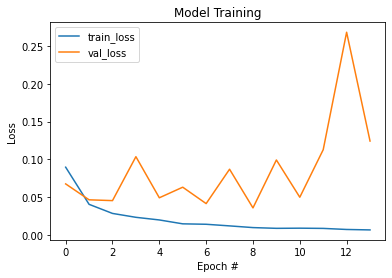

In [60]:
plt.plot(second_mnist_history.history["loss"], label="train_loss")
plt.plot(second_mnist_history.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/SecondMNISTLoss.png")

###Second MNIST Pretrained Accuracy Analysis

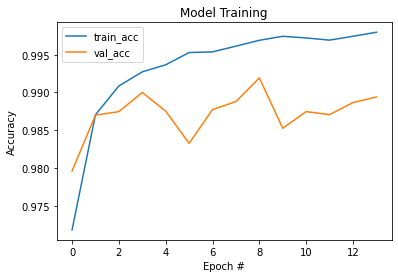

In [61]:
plt.plot(second_mnist_history.history["accuracy"], label="train_acc")
plt.plot(second_mnist_history.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/SecondMNISTAccuracy.png")

In [62]:
X_test_new = np.zeros((X_test_mnist.shape[0], X_test_mnist.shape[1], X_test_mnist.shape[2], 3))
for i in range(X_test_mnist.shape[0]):
  X_test_new[i, :, :, :] = np.stack((X_test_mnist[i, :, :],)*3, axis=-1)

In [63]:
X_test_mnist = np.zeros(X_test_new.shape)
X_test_mnist = X_test_new

In [64]:
X_test_mnist.shape

(10000, 28, 28, 3)

In [65]:
Y_test_mnist.shape

(10000, 10)

In [66]:
lee_mnist.evaluate(X_test_mnist, Y_test_mnist, batch_size=32, verbose = 2)

313/313 - 3s - loss: 0.0315 - accuracy: 0.9922


[0.03154076263308525, 0.9922000169754028]

In [67]:
Y_test_mnist_max = np.argmax(Y_test_mnist, axis = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


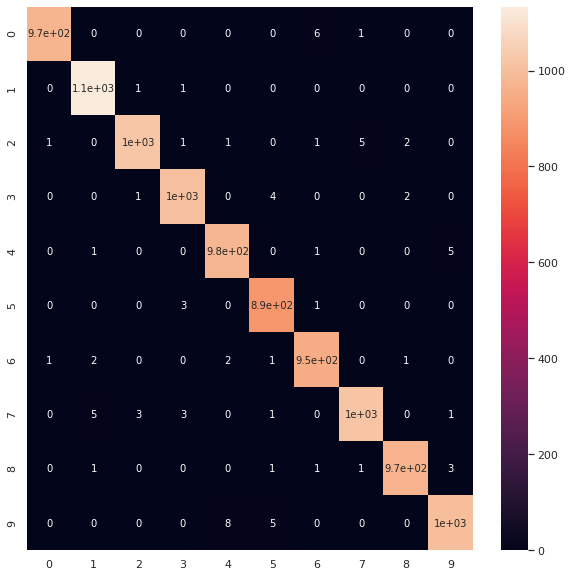

In [68]:
Y_pred_lee_mnist = lee_mnist.predict_classes(X_test_mnist)
lee_mnist_cm = confusion_matrix(Y_test_mnist_max, Y_pred_lee_mnist)
lee_mnist_cm = pd.DataFrame(lee_mnist_cm)
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.0)
sn.heatmap(lee_mnist_cm, annot=True, annot_kws={"size": 10})
plt.show()

### Second MNIST Random Model

In [69]:
second_random_model = Sequential()
second_random_model.add(Conv2D(32, kernel_size = (3, 3), activation="relu", input_shape=(28, 28, 3)))
second_random_model.add(MaxPooling2D())
second_random_model.add(Conv2D(64, activation="relu", kernel_size=(5, 5)))
second_random_model.add(MaxPooling2D())
second_random_model.add(Conv2D(128, activation="relu", kernel_size=(3, 3)))
second_random_model.add(MaxPooling2D())
second_random_model.add(Flatten())
second_random_model.add(Dense(256, activation="relu"))
second_random_model.add(BatchNormalization())
second_random_model.add(Dropout(0.2))
second_random_model.add(Dense(10, activation="softmax"))
second_random_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
second_random_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [70]:
second_random_checkpoint = ModelCheckpoint("checkpoints/second_random_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [71]:
second_mnist_random_history = second_random_model.fit(X_train_mnist, Y_train_mnist, epochs=50, batch_size=32, validation_data=(X_val_mnist, Y_val_mnist), callbacks=[early, second_random_checkpoint])

Epoch 1/50
1407/1407 [==============================] - 54s 38ms/step - loss: 0.2871 - accuracy: 0.9110 - val_loss: 0.1721 - val_accuracy: 0.9479

Epoch 00001: saving model to checkpoints/second_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_random_checkpoint/assets
Epoch 2/50
1407/1407 [==============================] - 54s 38ms/step - loss: 0.0749 - accuracy: 0.9769 - val_loss: 0.1713 - val_accuracy: 0.9398

Epoch 00002: saving model to checkpoints/second_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_random_checkpoint/assets
Epoch 3/50
1407/1407 [==============================] - 53s 38ms/step - loss: 0.0399 - accuracy: 0.9876 - val_loss: 0.0600 - val_accuracy: 0.9820

Epoch 00003: saving model to checkpoints/second_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/second_random_checkpoint/assets
Epoch 4/50
1407/1407 [==============================] - 53s 38ms/step - loss: 0.0291 - accuracy: 0.9915 - val_loss: 0.0676 -

In [72]:
second_random_model.save("second_random_model.hd5")

INFO:tensorflow:Assets written to: second_random_model.hd5/assets


###Second MNIST Random Loss Analysis

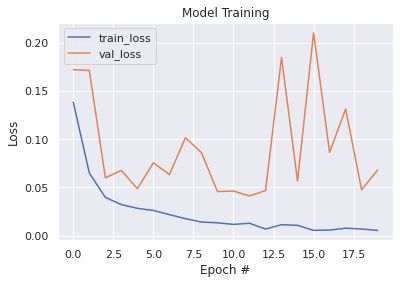

In [73]:
plt.plot(second_mnist_random_history.history["loss"], label="train_loss")
plt.plot(second_mnist_random_history.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/SecondMNISTRandomLoss.png")

###Second MNIST Random Accuracy Analysis

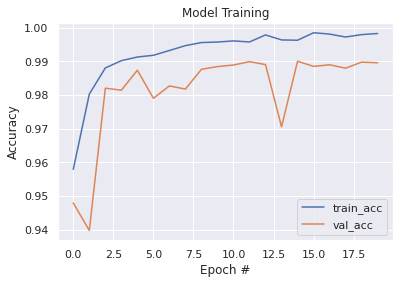

In [74]:
plt.plot(second_mnist_random_history.history["accuracy"], label="train_acc")
plt.plot(second_mnist_random_history.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/SecondMNISTRandomAccuracy.png")

In [75]:
second_random_model.evaluate(X_test_mnist, Y_test_mnist, batch_size = 32, verbose = 2)

313/313 - 3s - loss: 0.0283 - accuracy: 0.9926


[0.028332630172371864, 0.9926000237464905]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


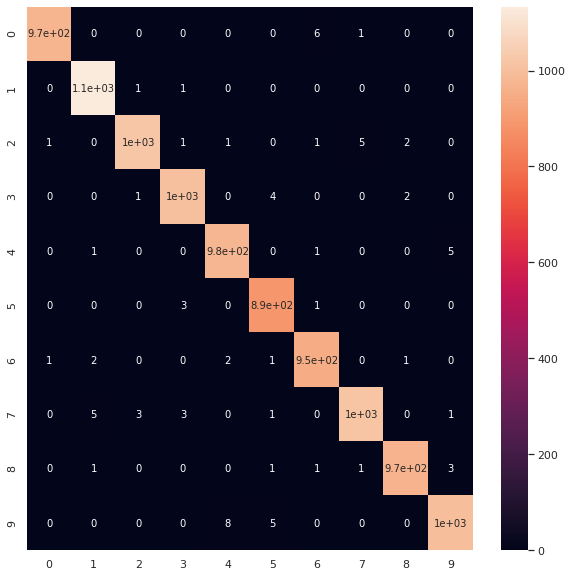

In [77]:
Y_pred_second_random = second_random_model.predict_classes(X_test_mnist)
second_random_cm = confusion_matrix(Y_test_mnist_max, Y_pred_second_random)
second_random_cm = pd.DataFrame(lee_mnist_cm)
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.0)
sn.heatmap(second_random_cm, annot=True, annot_kws={"size": 10})
plt.show()

## Part 3

###Importing Part 3 dataset

In [78]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
def create_dataset_last(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2GRAY)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
X_third, Y_third = create_dataset_last(r'/content/drive/MyDrive/mnistTask/mnistTask')

In [79]:
X_train_third, X_test_third, Y_train_third, Y_test_third = train_test_split(X_third, Y_third, test_size=0.2)

In [80]:
encoder_third = OneHotEncoder(sparse=False)
Y_train_third = np.array(Y_train_third)
Y_test_third = np.array(Y_test_third)
Y_train_third = Y_train_third.reshape(-1,1)
Y_test_third = Y_test_third.reshape(-1, 1)
Y_train_third = encoder_third.fit_transform(Y_train_third)
Y_test_third = encoder_third.transform(Y_test_third)

In [81]:
X_train_third = np.array(X_train_third)
X_train_third.shape

(48000, 28, 28)

In [82]:
X_test_third = np.array(X_test_third)
X_test_third.shape

(12000, 28, 28)

In [83]:
Y_train_third.shape

(48000, 10)

In [84]:
Y_test_third.shape

(12000, 10)

In [85]:
X_train_new = np.zeros((X_train_third.shape[0], X_train_third.shape[1], X_train_third.shape[2], 3))
for i in range(X_train_third.shape[0]):
  X_train_new[i, :, :, :] = np.stack((X_train_third[i, :, :],)*3, axis=-1)
X_train_third = X_train_new

In [86]:
X_train_third.shape

(48000, 28, 28, 3)

In [87]:
X_test_new = np.zeros((X_test_third.shape[0], X_test_third.shape[1], X_test_third.shape[2], 3))
for i in range(X_test_third.shape[0]):
  X_test_new[i, :, :, :] = np.stack((X_test_third[i, :, :],)*3, axis=-1)
X_test_third = X_test_new

In [88]:
X_test_third.shape

(12000, 28, 28, 3)

###Jumbled Pretrained Model

In [89]:
jumbled_model = clone_model(model_part_one)
jumbled_model.set_weights(model_part_one.get_weights())

In [90]:
jumbled_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [91]:
jumbled_model_third = Sequential(jumbled_model.layers[:-1])
jumbled_model_third.add(Dense(10, activation="softmax"))

In [92]:
jumbled_model_third.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)              

In [93]:
jumbled_model_third_checkpoint = ModelCheckpoint("checkpoints/jumbled_model_third_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [94]:
jumbled_model_third.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [95]:
jumbled_third_history = jumbled_model_third.fit(X_train_third, Y_train_third, epochs=50, validation_data=(X_test_third, Y_test_third), verbose=2, batch_size = 32, callbacks=[early, jumbled_model_third_checkpoint])

Epoch 1/50
1500/1500 - 52s - loss: 2.4184 - accuracy: 0.1078 - val_loss: 2.2865 - val_accuracy: 0.1123

Epoch 00001: saving model to checkpoints/jumbled_model_third_checkpoint
INFO:tensorflow:Assets written to: checkpoints/jumbled_model_third_checkpoint/assets
Epoch 2/50
1500/1500 - 51s - loss: 2.2861 - accuracy: 0.1163 - val_loss: 2.2765 - val_accuracy: 0.1172

Epoch 00002: saving model to checkpoints/jumbled_model_third_checkpoint
INFO:tensorflow:Assets written to: checkpoints/jumbled_model_third_checkpoint/assets
Epoch 3/50
1500/1500 - 51s - loss: 2.2603 - accuracy: 0.1218 - val_loss: 2.2731 - val_accuracy: 0.1112

Epoch 00003: saving model to checkpoints/jumbled_model_third_checkpoint
INFO:tensorflow:Assets written to: checkpoints/jumbled_model_third_checkpoint/assets
Epoch 4/50
1500/1500 - 51s - loss: 2.2461 - accuracy: 0.1286 - val_loss: 2.2740 - val_accuracy: 0.1119

Epoch 00004: saving model to checkpoints/jumbled_model_third_checkpoint
INFO:tensorflow:Assets written to: checkp

In [96]:
jumbled_model_third.save("jumbled_model_third.hd5")

INFO:tensorflow:Assets written to: jumbled_model_third.hd5/assets


###Jumbled Pretrained Loss Analysis

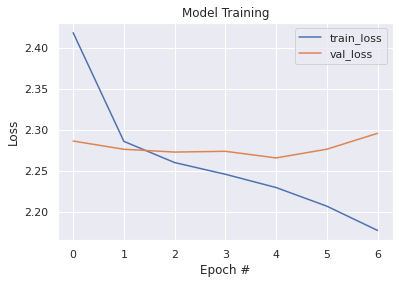

In [97]:
plt.plot(jumbled_third_history.history["loss"], label="train_loss")
plt.plot(jumbled_third_history.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/JumbledThirdLoss.png")

###Jumbled Pretrained Accuracy Analysis

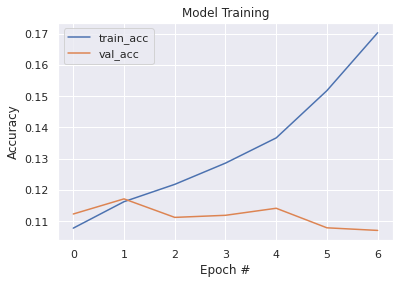

In [98]:
plt.plot(jumbled_third_history.history["accuracy"], label="train_acc")
plt.plot(jumbled_third_history.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/JumbledThirdAccuracy.png")

In [99]:
jumbled_model_third.evaluate(X_test_mnist, Y_test_mnist, batch_size=32, verbose = 3)

[666.9180297851562, 0.008299999870359898]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


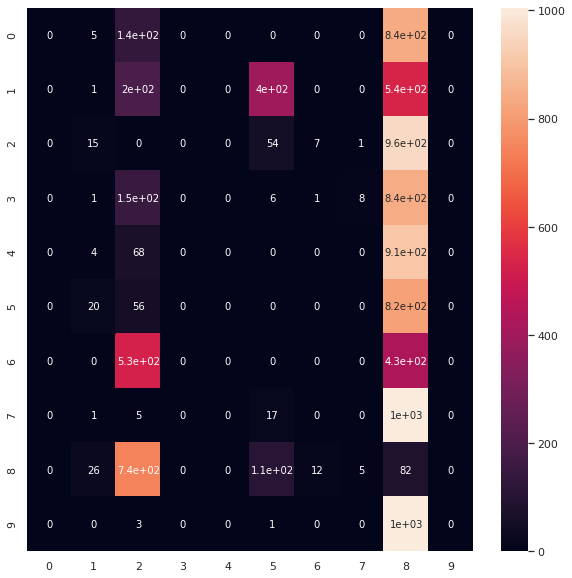

In [102]:
Y_pred_jumbled_third = jumbled_model_third.predict_classes(X_test_mnist)
jumbled_third_cm = confusion_matrix(Y_test_mnist_max, Y_pred_jumbled_third)
jumbled_third_cm = pd.DataFrame(jumbled_third_cm)
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.0)
sn.heatmap(jumbled_third_cm, annot=True, annot_kws={"size": 10})
plt.show()

### Jumbled Random Model 

In [103]:
jumbled_model_third_random = Sequential()
jumbled_model_third_random.add(Conv2D(32, kernel_size = (3, 3), activation="relu", input_shape=(28, 28, 3)))
jumbled_model_third_random.add(MaxPooling2D())
jumbled_model_third_random.add(Conv2D(64, activation="relu", kernel_size=(5, 5)))
jumbled_model_third_random.add(MaxPooling2D())
jumbled_model_third_random.add(Conv2D(128, activation="relu", kernel_size=(3, 3)))
jumbled_model_third_random.add(MaxPooling2D())
jumbled_model_third_random.add(Flatten())
jumbled_model_third_random.add(Dense(256, activation="relu"))
jumbled_model_third_random.add(BatchNormalization())
jumbled_model_third_random.add(Dropout(0.2))
jumbled_model_third_random.add(Dense(10, activation="softmax"))
jumbled_model_third_random.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
jumbled_model_third_random.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

In [104]:
jumbled_model_third_random.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [105]:
jumbled_model_third_random_checkpoint = ModelCheckpoint("checkpoints/jumbled_model_third_random_checkpoint", monitor="val_accuracy", verbose = 2, save_best_only = False, save_weights_only = False)

In [106]:
jumbled_model_random_history = jumbled_model_third_random.fit(X_train_third, Y_train_third, epochs=50, validation_data=(X_test_third, Y_test_third), verbose=2, batch_size = 32, callbacks=[early, jumbled_model_third_random_checkpoint])

Epoch 1/50
1500/1500 - 53s - loss: 2.3002 - accuracy: 0.1108 - val_loss: 2.3099 - val_accuracy: 0.1081

Epoch 00001: saving model to checkpoints/jumbled_model_third_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/jumbled_model_third_random_checkpoint/assets
Epoch 2/50
1500/1500 - 50s - loss: 2.2782 - accuracy: 0.1122 - val_loss: 2.4012 - val_accuracy: 0.1086

Epoch 00002: saving model to checkpoints/jumbled_model_third_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/jumbled_model_third_random_checkpoint/assets
Epoch 3/50
1500/1500 - 50s - loss: 2.2722 - accuracy: 0.1164 - val_loss: 2.3875 - val_accuracy: 0.1057

Epoch 00003: saving model to checkpoints/jumbled_model_third_random_checkpoint
INFO:tensorflow:Assets written to: checkpoints/jumbled_model_third_random_checkpoint/assets
Epoch 4/50
1500/1500 - 50s - loss: 2.2653 - accuracy: 0.1220 - val_loss: 2.3357 - val_accuracy: 0.1113

Epoch 00004: saving model to checkpoints/jumbled_model_third_random_che

In [107]:
jumbled_model_third_random.save("jumbled_model_third_random.hd5")

INFO:tensorflow:Assets written to: jumbled_model_third_random.hd5/assets


###Jumbled Random Loss Analysis

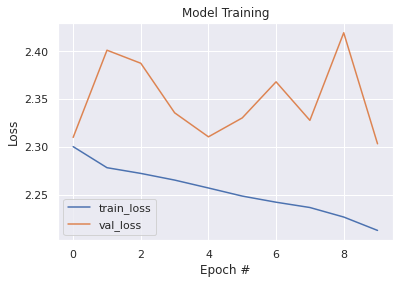

In [108]:
plt.plot(jumbled_model_random_history.history["loss"], label="train_loss")
plt.plot(jumbled_model_random_history.history["val_loss"], label="val_loss")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("images/JumbledThirdRandomLoss.png")

###Jumbled Random Accuracy Analysis

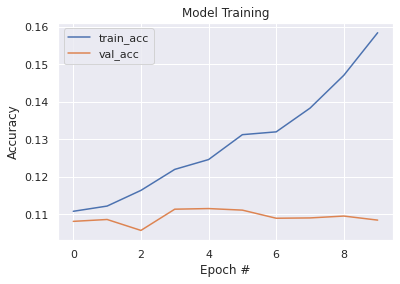

In [109]:
plt.plot(jumbled_model_random_history.history["accuracy"], label="train_acc")
plt.plot(jumbled_model_random_history.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("images/JumbledThirdRandomAccuracy.png")

In [110]:
jumbled_model_third_random.evaluate(X_test_mnist, Y_test_mnist, batch_size=32, verbose = 3)

[370.3474426269531, 0.10689999908208847]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


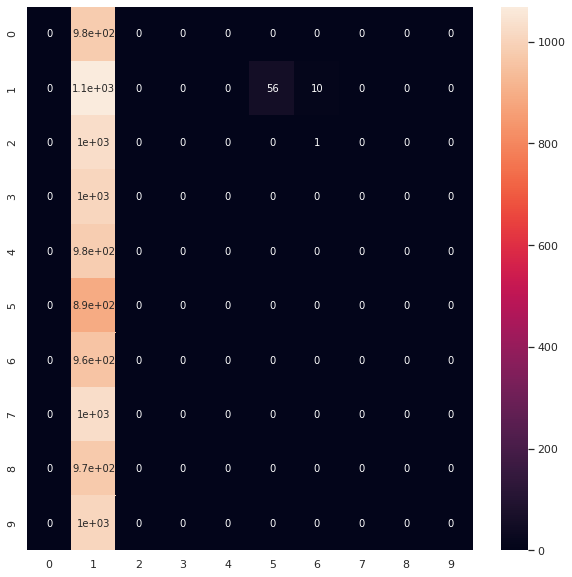

In [111]:
Y_pred_jumbled_third_random = jumbled_model_third_random.predict_classes(X_test_mnist)
jumbled_third_random_cm = confusion_matrix(Y_test_mnist_max, Y_pred_jumbled_third_random)
jumbled_third_random_cm = pd.DataFrame(jumbled_third_random_cm)
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.0)
sn.heatmap(jumbled_third_random_cm, annot=True, annot_kws={"size": 10})
plt.show()